In [116]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
import math as math
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

# Grovers Algorithm 
## Introduction

Time complexity is a representation of the time taken by an algorithm to solve a problem as a function relative to the size of the input data. This property is commonly expressed in $\mathcal{O}$ ("Big O") notation which represents the upper bound of the number of steps needed to solve the problem.

If you have $N$ randomly ordered elements and you need to find a particular element, in classical computing the time complexity is $\mathcal{O}(N)$.

In the context of quantum computing, Grover's algorithm seeks to find a particular element with $\mathcal{O}(\sqrt{N})$ time complexity. The decreased time complexity is due to the superposition of states, which allows for simultaneous examination of multiple elements.

This report aims to examine Grovers Algorithm and create an executable demo using 'qutip' (Quantum Toolbox in Python)

by Jessie Lonsdale and Anastasios Mavridis.

In [2]:
def generate_search_problem(length):
    haystack = '0' * int(math.pow(2,length))
    needle = np.random.randint(0,int(math.pow(2,length))-1)
    return (haystack[:needle]+'1'+haystack[needle + 1:]), needle

In [105]:
def grovers_circuit(haystack,needle):
    string_length = int(len(haystack))
    number_of_qubits = int(math.log(string_length, 2))
    
    # Initialize data qubits using list comprehension
    qubits = [qt.basis(2, 0) for _ in range(number_of_qubits)]

    # Add control qubit
    qubits.append(qt.basis(2, 1))

    Q = None
    for qubit in qubits:
        if Q:
            Q = qt.tensor(Q,qubit)
        else:
            Q = qt.tensor(qubit)

    H = None
    for qubit in qubits:
        if H:
            H = qt.tensor(H,qt.hadamard_transform(1))
        else:
            H = qt.hadamard_transform(1)
    
    Uf = np.zeros((string_length*2, string_length*2), dtype=int)
    for i in range(string_length):
        if haystack[i] == '0':
            Uf[i*2,i*2] = '1'
            Uf[i*2+1,i*2+1] = '1'
        else:
            Uf[i*2+1,i*2] = '1'
            Uf[i*2,i*2+1] = '1'
    
    # create HxI, CxZI and XxI gates
    HxI_gates = [qt.hadamard_transform(1) for _ in range(len(qubits)-1)]
    HxI_gates.append(qt.qeye(2))
    HxI = qt.tensor(HxI_gates)

    XxI_gates = [qt.sigmax() for _ in range(len(qubits)-1)]
    XxI_gates.append(qt.qeye(2))
    XxI = qt.tensor(XxI_gates)

    CxZI = np.zeros([string_length,string_length])
    for i in range(int(string_length-1)):
        CxZI[i,i] = 1
    CxZI[string_length-1,string_length-1] = -1
    CxZI = qt.tensor(qt.Qobj(CxZI), qt.qeye(2))
    CxZI.dims = HxI.dims

    # Diffusion operator
    Dif = HxI * XxI * CxZI * XxI * HxI
    
    # Begin with applying H to Q
    current_state = H * Q

    # Now repeat Uf and Dif <repeat> times.  This is the Grover Iteration.
    for i in range(int((math.pi/4) * math.sqrt(2**(number_of_qubits)))):
        current_state = Uf * current_state
        current_state = Dif * current_state
        current_state = qt.Qobj(current_state)
    return current_state


C:\Users\lonsd\AppData\Local\Temp\ipykernel_8264\3600943078.py:23: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  H = qt.hadamard_transform(1)
C:\Users\lonsd\AppData\Local\Temp\ipykernel_8264\3600943078.py:21: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  H = qt.tensor(H,qt.hadamard_transform(1))
C:\Users\lonsd\AppData\Local\Temp\ipykernel_8264\3600943078.py:35: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.q

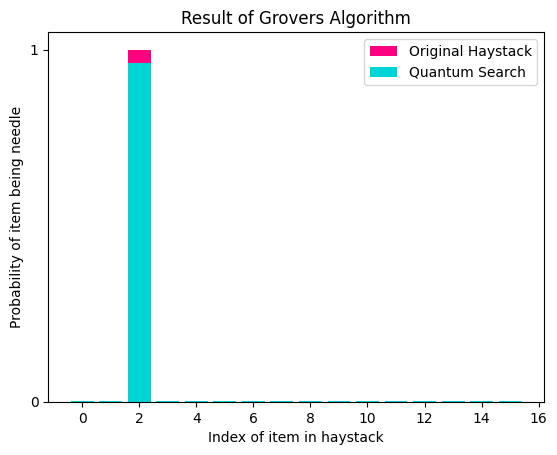

In [115]:
haystack, needle = generate_search_problem(4)
res = grovers_circuit(haystack, needle)
pairs = []

result = res.full()

for i in range(0, len(result), 2):
    item = (result[i+1]**2)+(result[i]**2)
    pairs.append(item[0])   
    
# Create a bar chart
plt.bar(np.arange(len(list(haystack))), list(haystack), color='#FF007F', label='Original Haystack')
plt.bar(np.arange(len(pairs)), pairs,  color='#00D5D5', label='Quantum Search')


# Add labels and title
plt.xlabel('Index of item in haystack')
plt.ylabel('Probability of item being needle')
plt.title('Result of Grovers Algorithm')

# Display the chart
plt.legend()
plt.show()

# 